# Preamble

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import re
from glob import glob
from astropy.table import Table, Column
from tqdm.notebook import tqdm
from scikitplot.metrics import plot_confusion_matrix

plt.rcParams['figure.figsize'] = (20, 10)

PICKLES_SEDS = glob('/home/aalvarez/Phosphoros/AuxiliaryData/SEDs/Pickles/*/*.sed')
SURVEY_SET = ['euclid', 'lsst', 'des', 'kids']
FILTER_COLOR = dict(
    u = 'blueviolet',
    g = 'green',
    r = 'red',
    VIS = 'blue',
    i = 'darkred',
    z = 'pink',
    H = 'brown',
    J = 'indianred',
    Y = 'gray',
    y = 'gray',
)
SPECTRAL_NAMES = np.array(['O', 'B', 'A', 'F', 'G', 'K', 'M'])
LUMINOSITY_NAMES = np.flip(np.array(['I', 'II', 'III', 'IV', 'V']))
SPECTRAL_DETAILED = np.array([
    'O5', 'O8', 'O9',
    'B0', 'B1', 'B12', 'B2', 'B3', 'B5', 'B57', 'B6', 'B8', 'B9',
    'A0', 'A2', 'A3', 'A47', 'A5', 'A7', 
    'F0', 'F02', 'F2', 'F5', 'F6', 'F8',
    'G0', 'G2', 'G5', 'G8',
    'K0', 'K01', 'K1', 'K2', 'K3', 'K34', 'K4', 'K5', 'K7',
    'M0', 'M1', 'M10', 'M2', 'M2.5', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9', 
])

FILTER_TRANSMISSION = dict()
SED_LIB = Table.read('/home/aalvarez/Work/Data/SC7/TU/Stars/Deep/EUC-TEST-SEDLIB-2013-11-14_MODIF.fits')
TEMP_TO_SPECTRAL = Table([
    Column(['O', 'B', 'A', 'F', 'G', 'K', 'M'], name='T'),
    Column([30000, 10000, 7500, 6000, 5200, 3700, 0.], name='MIN'),
    Column([np.inf, 30000, 10000, 7500, 6000, 5200, 3700], name='MAX')
])
CATALOG_FLUX_NAMES = [
    "TU_FNU_VIS", "TU_FNU_Y_NISP", "TU_FNU_J_NISP", "TU_FNU_H_NISP", 
    "TU_FNU_G_DECAM", "TU_FNU_R_DECAM", "TU_FNU_I_DECAM", "TU_FNU_Z_DECAM", 
    "TU_FNU_U_MEGACAM", "TU_FNU_R_MEGACAM", "TU_FNU_G_JPCAM", 
    "TU_FNU_I_PANSTARRS", "TU_FNU_Z_PANSTARRS", "TU_FNU_Z_HSC", "TU_FNU_U_LSST", 
    "TU_FNU_G_LSST", "TU_FNU_R_LSST", "TU_FNU_I_LSST", "TU_FNU_Z_LSST"
]

In [2]:
SED_RE = re.compile('uk([rw]?)(\w\d+(\.\d+)?)(\w+)')

def classes_from_sed_name(sed):
    """
    From the sed filename, extract luminosity and spectral class (in this order)
    """
    filename = os.path.basename(sed)
    if filename.endswith('.sed'):
        filename = filename[:-4]
    match = SED_RE.match(filename)
    assert match is not None, sed
    return match.group(4).upper(), match.group(2).upper()

def categorical_hist(ax, data, labels, density=True, **kwargs):
    """
    Plot an histogram of categorical classes following the order given in labels
    """
    sorter = np.argsort(labels)
    data_idx = sorter[np.searchsorted(labels, data, sorter=sorter)]
    ax.hist(data_idx, bins=np.arange(-0.5, len(labels)), density=density)
    ax.set_xticks(np.arange(0, len(labels)))
    ax.set_xticklabels(labels, **kwargs.get('ticks', {}))

# Introduction

We are using Phosphoros to perform model fitting over a set of "ideal" star photometries form the True Universe Catalog (Deep).
We need the fitted SEDs to compute the fluxes for the Intermediate Bands, and, later on, with NNPZ obtain the mean photometries
for these bands on the Wide TU sample.


## Filters

For the model fitting, we will can use Euclid's `VIS`, `H`, `J` and `Y` bands; LSST `ugriz`; DES `griz`; and KiDS `ugri`.
Note that this does not necessarily means we do the fitting with all of them. 

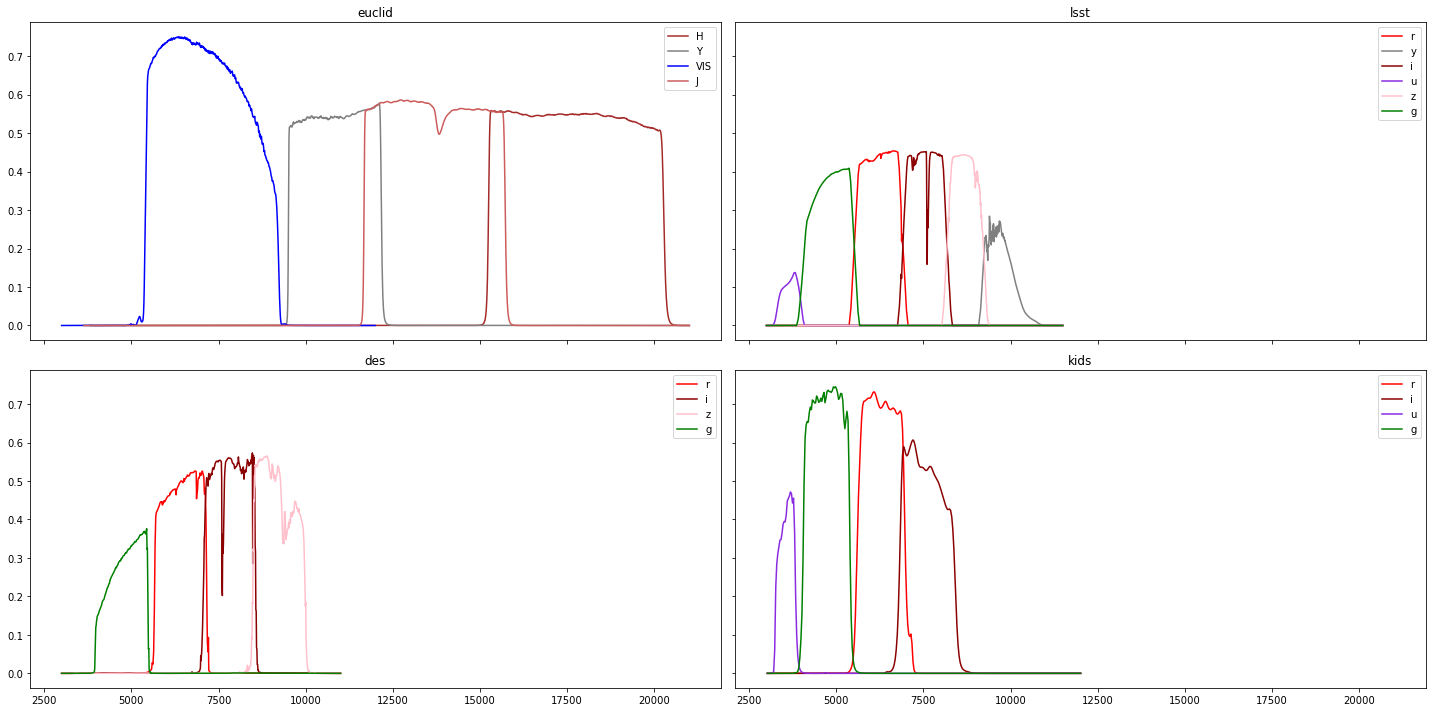

In [3]:
fig, axes = plt.subplots(2, 2, sharex=True, sharey=True)
for survey, ax in zip(SURVEY_SET, axes.ravel()):
    ax.set_title(survey)
    for f in glob(os.path.join('/home/aalvarez/Phosphoros/AuxiliaryData/Filters/', survey, '*.dat')):
        f_trans = np.loadtxt(f)
        f_name = os.path.basename(f).split('.')[0]
        FILTER_TRANSMISSION[f'{survey}/{f_name}'] = f_trans
        ax.plot(f_trans[:,0], f_trans[:,1], c=FILTER_COLOR[f_name], label=f_name)
    ax.legend()
plt.tight_layout()

## SEDs

The SEDs are Pickle's, and obtained from the [ESO Webpage](https://www.eso.org/sci/facilities/paranal/decommissioned/isaac/tools/lib.html).
Note that those SEDs have [multiple columns](https://www.eso.org/sci/facilities/paranal/decommissioned/isaac/tools/lib/hilib.pdf):

> Each file lists wavelength from 1150|25000 Å, at 5Å/pixel steps in the first column, the corresponding $F_\lambda$ in column 2, the standard deviation of the combination in column 3, the spectrum from UVILIB in column 4, and the infrared source spectra in subsequent columns.

As Phosphoros expects only $\lambda$ and $F_\lambda$, we extract only the first two columns. They are already on a format Phosphoros supports.
From the manual:

> SED Templates: the first column contains the wavelength values expressed in Å and the second column the flux expressed in erg/s/cm2/A˚.

Let's plot some SEDs with together with the Euclid and LSST bands.

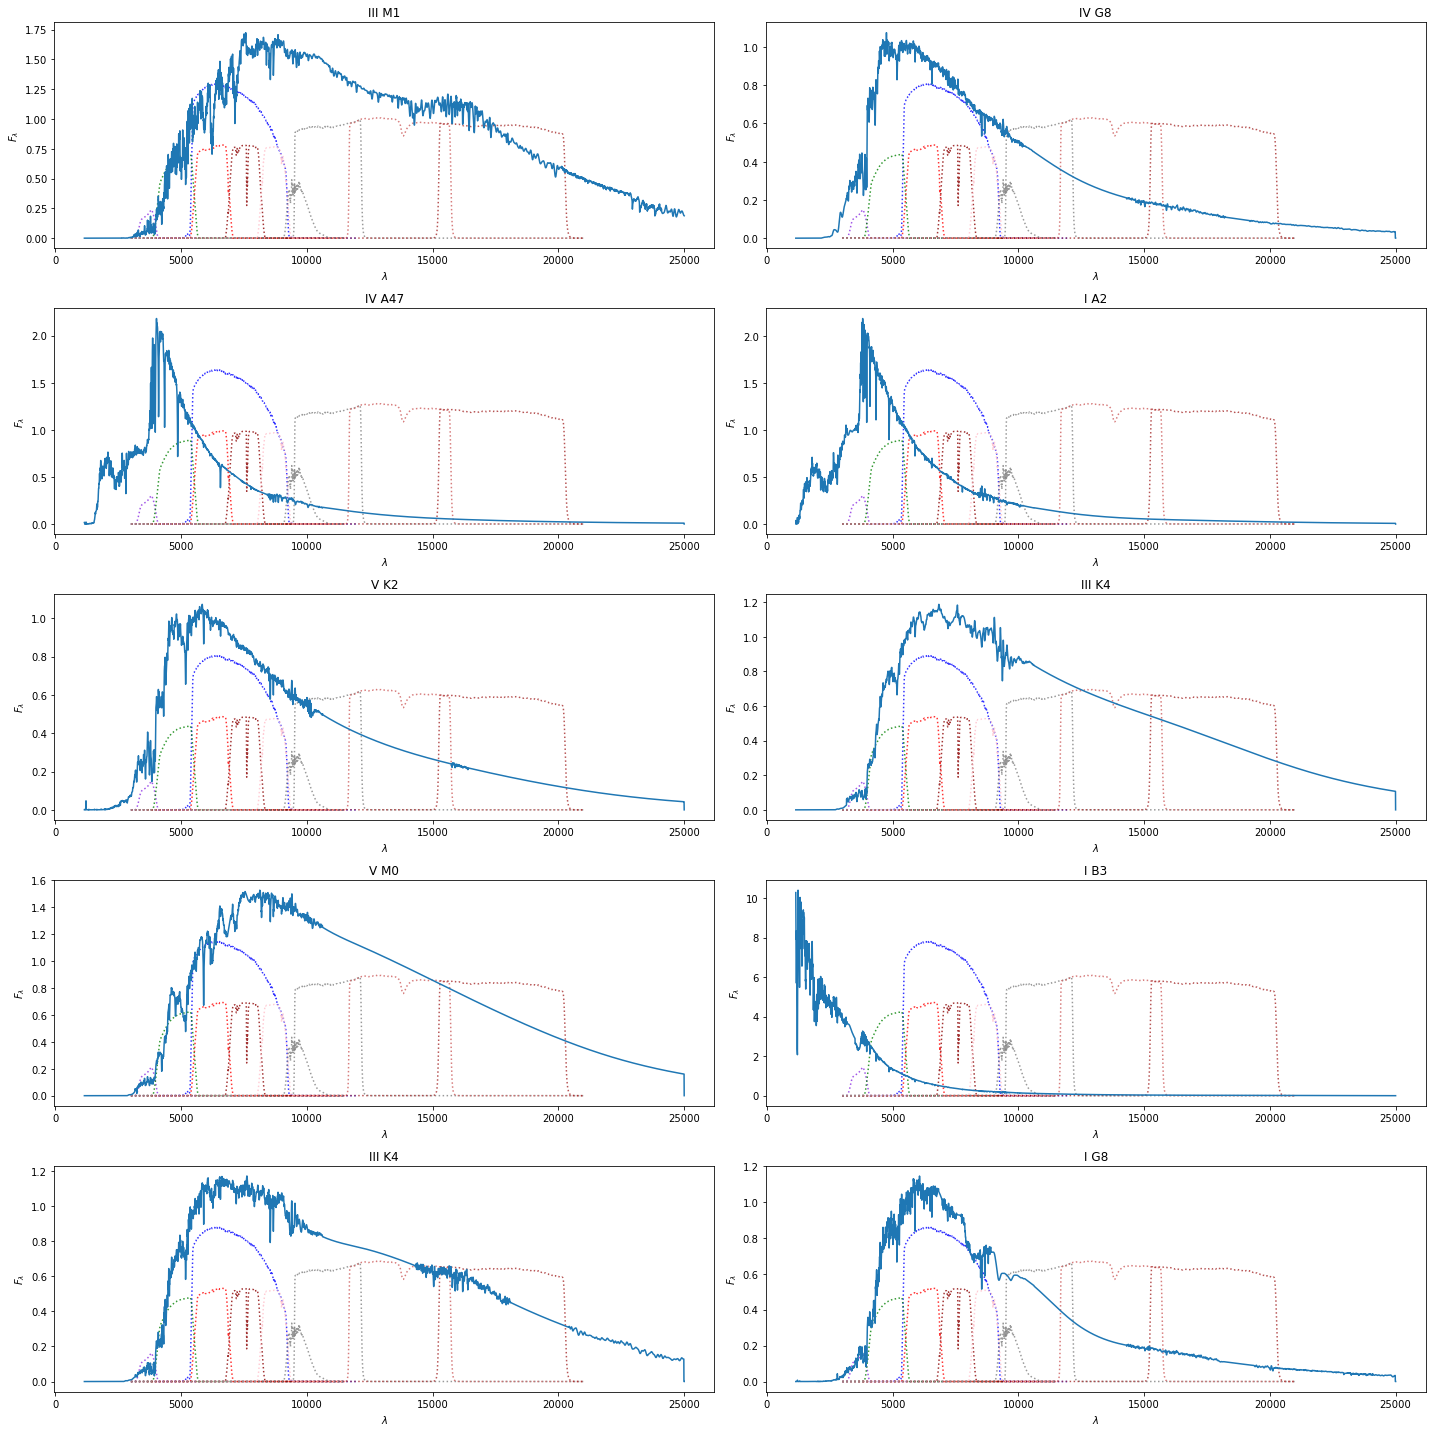

In [4]:
sed_sample = np.random.choice(PICKLES_SEDS, 10, replace=False)
fig, axes = plt.subplots(5, 2, figsize=(20, 20))
for sed_file, ax in zip(sed_sample, axes.ravel()):
    sed = np.loadtxt(sed_file)
    max_sed = np.max(sed[:,1])
    # Filters
    for f in ['VIS', 'Y', 'J', 'H']:
        trans = FILTER_TRANSMISSION[f'euclid/{f}']
        ax.plot(trans[:,0], trans[:,1] * max_sed, c=FILTER_COLOR[f], alpha=0.8, linestyle=':')
    for f in ['u', 'g', 'r', 'i', 'z', 'y']:
        trans = FILTER_TRANSMISSION[f'lsst/{f}']
        ax.plot(trans[:,0], trans[:,1] * max_sed, c=FILTER_COLOR[f], alpha=0.8, linestyle=':')
    # SED
    ax.plot(sed[:,0], sed[:,1])
    # Title and axes
    luminosity_class, spectral_class = classes_from_sed_name(sed_file)
    ax.set_title(f'{luminosity_class} {spectral_class}')
    ax.set_xlabel('$\lambda$')
    ax.set_ylabel('$F_\lambda$')
plt.tight_layout()

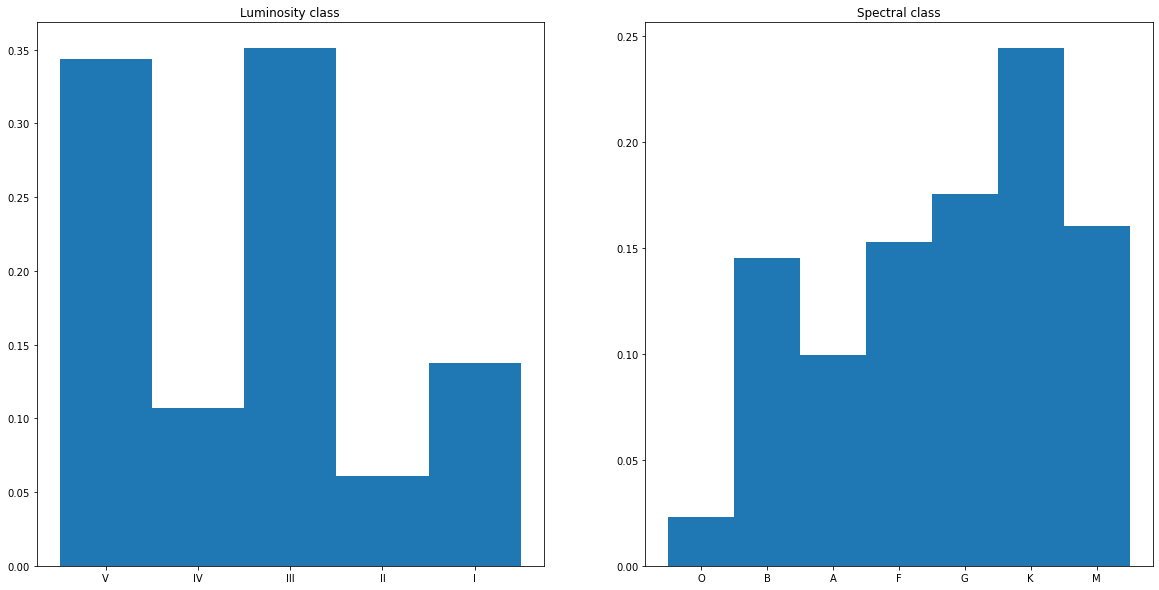

In [5]:
pickles_counts = {
    'luminosity': [],
    'spectral': []
}
for sed in PICKLES_SEDS:
    luminosity, spectral = classes_from_sed_name(sed)
    pickles_counts['luminosity'].append(luminosity)
    pickles_counts['spectral'].append(spectral[0])
fig, axes = plt.subplots(ncols=2)

categorical_hist(axes[0], pickles_counts['luminosity'], LUMINOSITY_NAMES)
axes[0].set_title('Luminosity class')

categorical_hist(axes[1], pickles_counts['spectral'], SPECTRAL_NAMES)
axes[1].set_title('Spectral class')
plt.show()

Those are our templates. Features on bright stars falls almost completely outside the range of the filters.

## TU SEDs

For the True Universe we do not have the actual SED, but an index to a catalog of SED templates, containing gravity (`LOGG`), temperature (`TEFF`) and 
metalicity (`FEH`).

We use the temperature to map to a spectral class.

**NOTE:** Can we get the luminosity type from the surface gravity?

In [6]:
TEMP_TO_SPECTRAL

T,MIN,MAX
str1,float64,float64
O,30000.0,inf
B,10000.0,30000.0
A,7500.0,10000.0
F,6000.0,7500.0
G,5200.0,6000.0
K,3700.0,5200.0
M,0.0,3700.0


In [7]:
TU_SEDS = []
for sed in tqdm(SED_LIB):
    match = np.logical_and(TEMP_TO_SPECTRAL['MIN'] < sed['TEFF'], sed['TEFF'] <= TEMP_TO_SPECTRAL['MAX'])
    assert match.sum() == 1
    TU_SEDS.append(TEMP_TO_SPECTRAL['T'][match][0])
TU_SEDS = np.array(TU_SEDS)

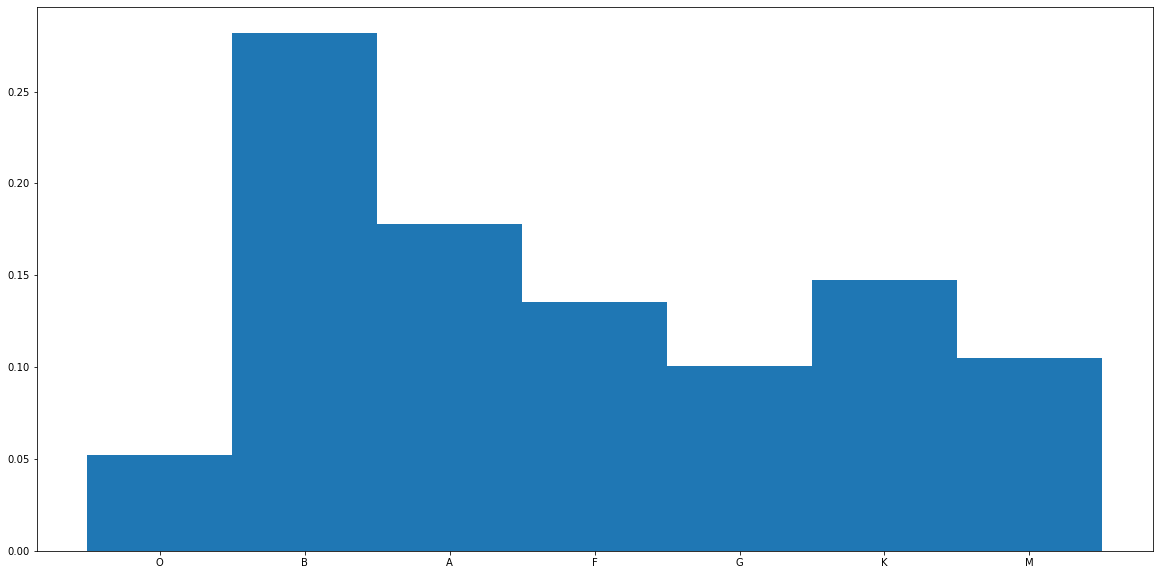

In [8]:
plt.figure()
categorical_hist(plt.gca(), TU_SEDS, SPECTRAL_NAMES)

Note that this is *the library*, not the actual number of stars we get on the TU Deep catalog.

## Photometry

We take the TU deep catalog, for which we have photometries in all the required bands, but without errors, which are computed on our side.

In [9]:
deep_input = Table.read('/home/aalvarez/Phosphoros/Catalogs/SC7_Stars/Deep.fits')
len(deep_input)

1724897

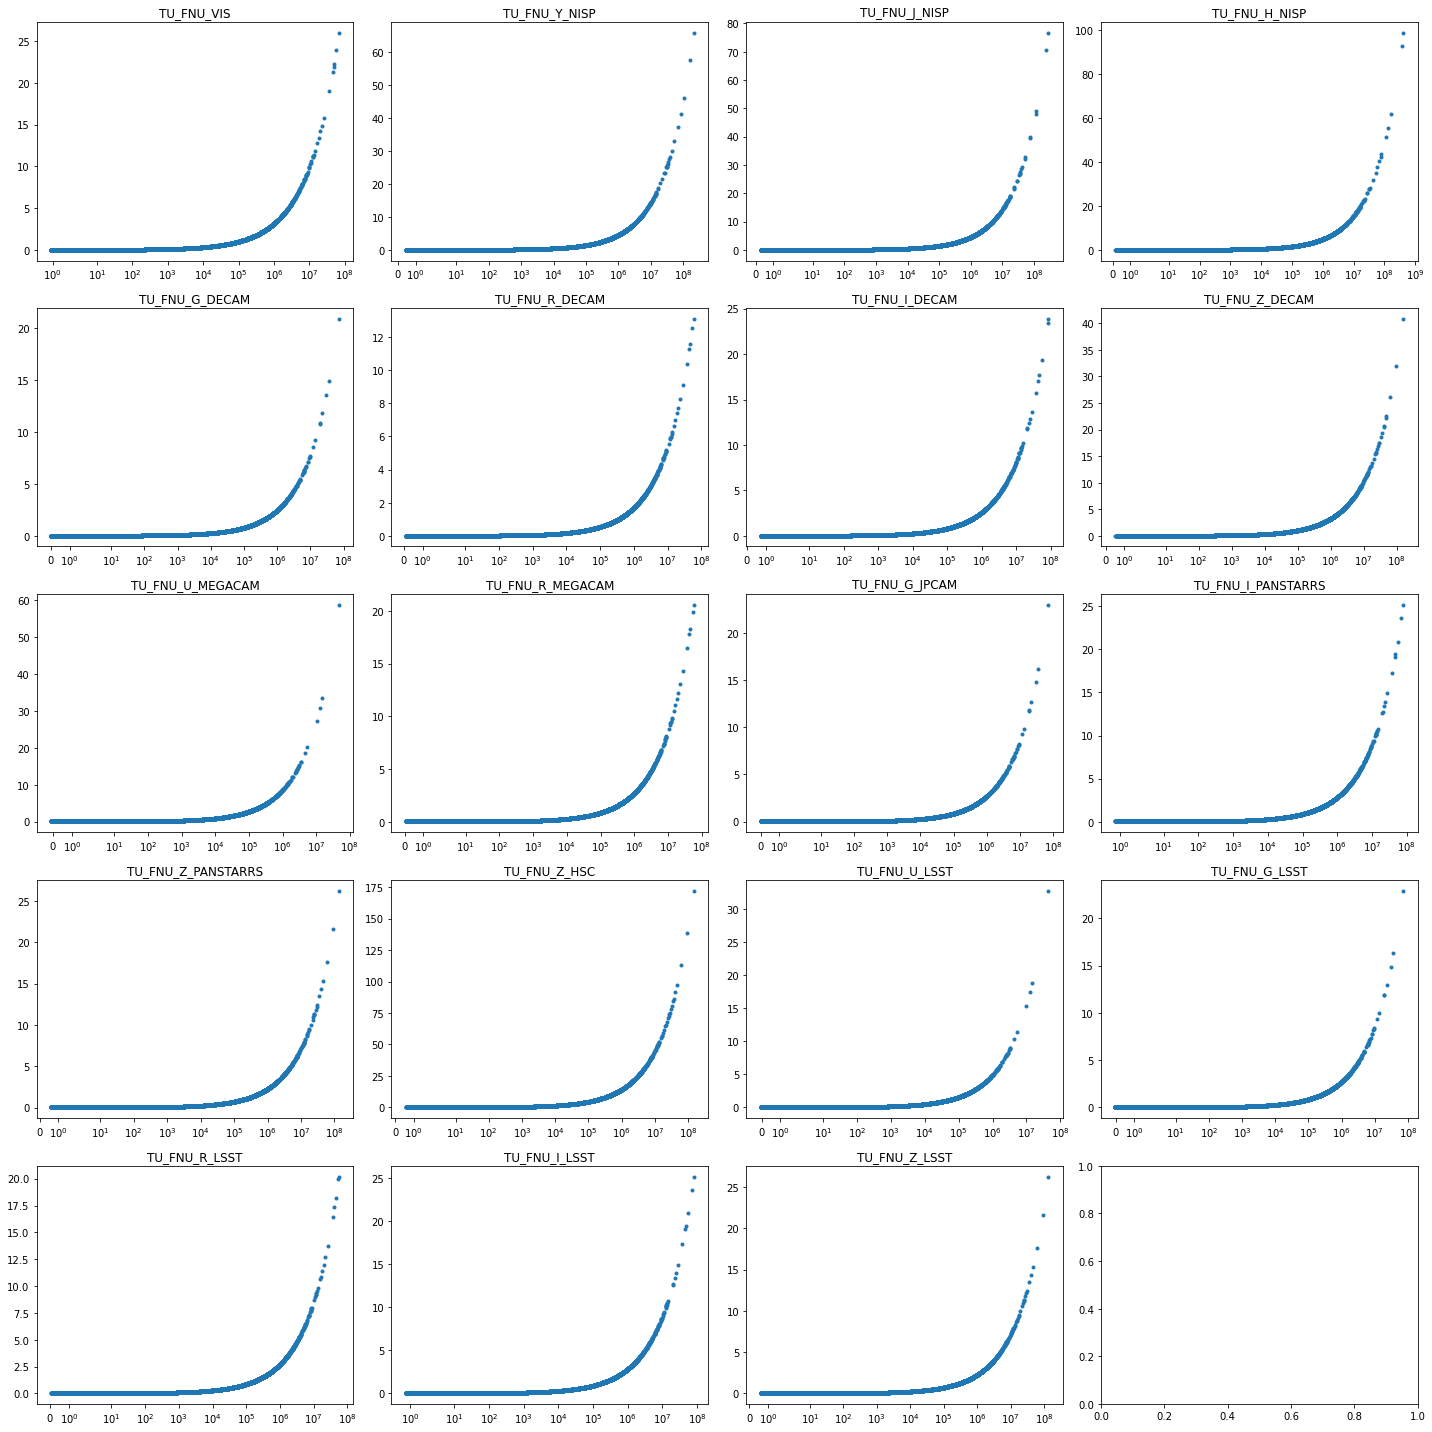

In [10]:
ncols = 4
nrows = len(CATALOG_FLUX_NAMES) // ncols + (len(CATALOG_FLUX_NAMES) % ncols > 0)

fig, axes = plt.subplots(ncols=ncols, nrows=nrows, figsize=(20, 20))
for flux_name, ax in zip(CATALOG_FLUX_NAMES, axes.ravel()):
    ax.scatter(deep_input[f'{flux_name}_obs'], deep_input[f'{flux_name}_obs_err'], marker='.')
    ax.set_xscale('symlog')
    ax.set_title(flux_name)
plt.tight_layout()

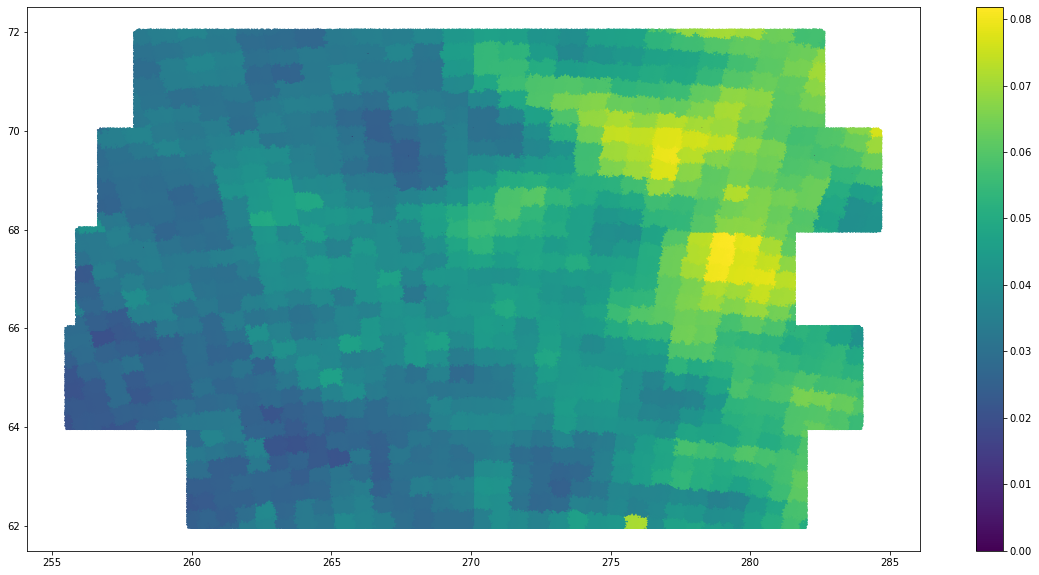

In [11]:
plt.figure()
plt.scatter(deep_input['RA'], deep_input['DEC'], c=deep_input['ebv'], marker='*')
plt.colorbar()

Let's have a look at the spectral class of this population:

In [12]:
def classes_from_tu_seds(template_idx):
    seds = SED_LIB[template_idx]
    spectral = []
    for sed in tqdm(seds):
        match = np.logical_and(TEMP_TO_SPECTRAL['MIN'] < sed['TEFF'], sed['TEFF'] <= TEMP_TO_SPECTRAL['MAX'])
        assert match.sum() == 1
        spectral.append(TEMP_TO_SPECTRAL['T'][match][0])
    return np.array(spectral)

In [13]:
spectral = classes_from_tu_seds(deep_input['SED_TEMPLATE'])

Text(0.5, 1.0, 'TU Spectral Class Distribution')

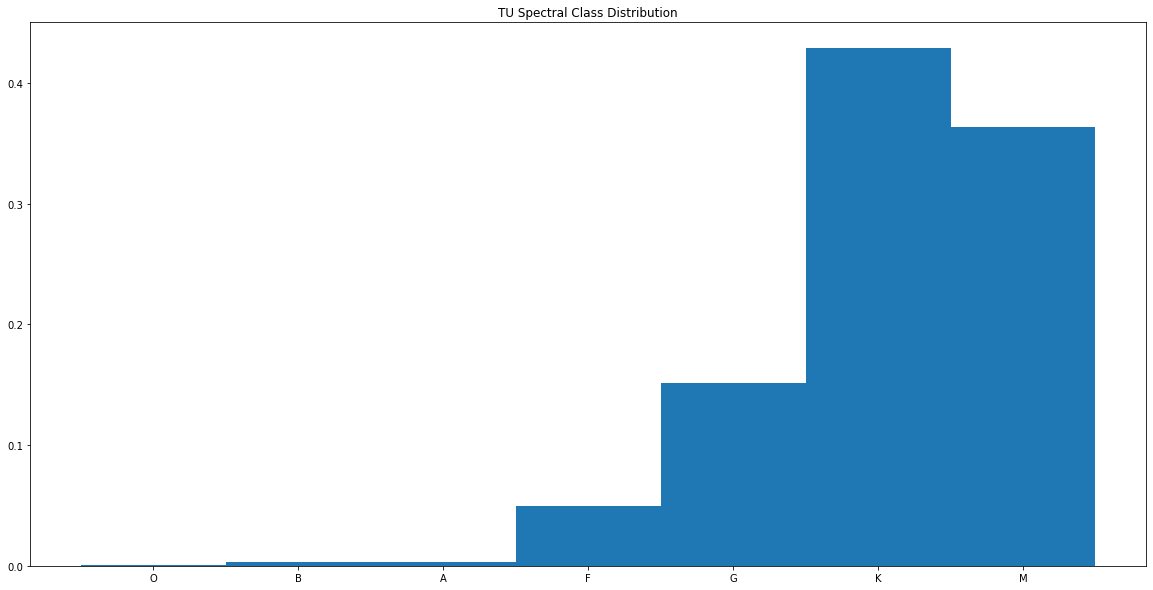

In [14]:
plt.figure()
categorical_hist(plt.gca(), spectral, SPECTRAL_NAMES)
plt.title('TU Spectral Class Distribution')

# Running Phosphoros

Shared configuration:

* Milkyway E(B-V) computed as $E(B-V) = \frac{AV}{3.2}$ [(1)](https://astronomy.swin.edu.au/cosmos/i/Interstellar+Reddening)
* 131 Pickle's SEDs
* F99 reddening curve
* Intrinsic E(B-V) left to 0
* Redshift left to 0
* IGM absorption `OFF`
* No priors
* No zero-point correction
* Fitting **best posterior model**

## Euclid + LSST (minus y), no SED weighting, MW absorption

In [15]:
deep_nw_lsst = Table.read('/home/aalvarez/Phosphoros/Results/SC7_Stars/Deep_NW_lsst/phz_cat.fits')
len(deep_nw_lsst)

1724897

In [16]:
def classes_from_sed_column(column):
    classes = {
        'spectral': [],
        'spectral_detailed': [],
        'luminosity': []
    }
    for sed in column:
        luminosity, spectral = classes_from_sed_name(sed)
        classes['spectral'].append(spectral[0])
        classes['spectral_detailed'].append(spectral)
        classes['luminosity'].append(luminosity)

    for k in classes:
        classes[k] = np.array(classes[k])
    return classes

In [17]:
deep_nw_lsst_classes = classes_from_sed_column(deep_nw_lsst['SED'])

Text(0.5, 1.0, 'Fitted Spectral Class Distribution')

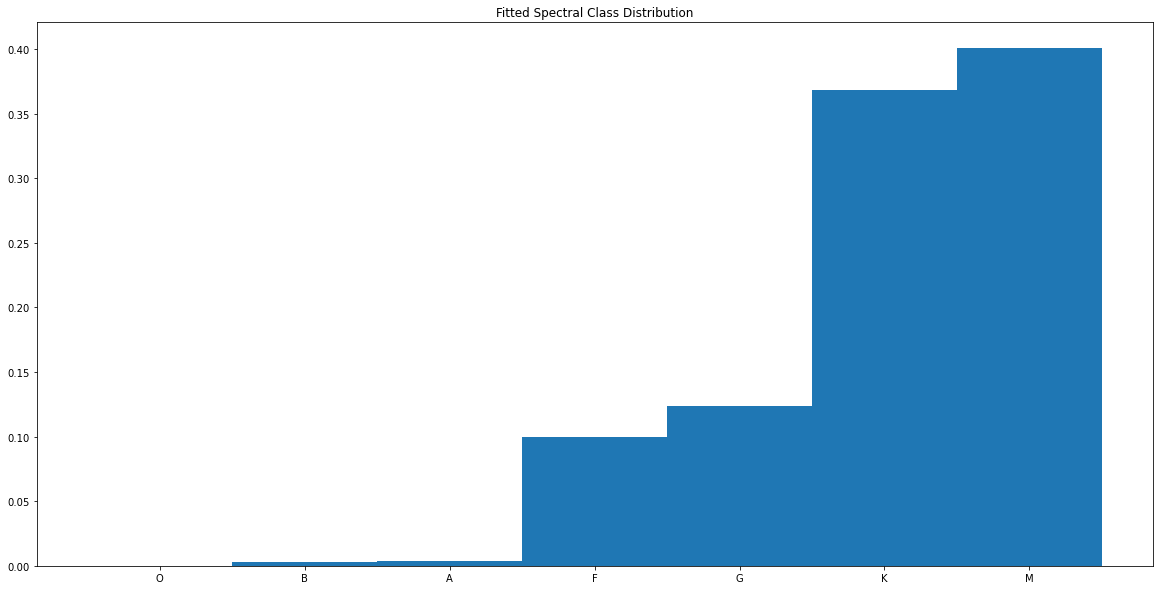

In [18]:
plt.figure()
categorical_hist(plt.gca(), deep_nw_lsst_classes['spectral'], SPECTRAL_NAMES)
plt.title('Fitted Spectral Class Distribution')

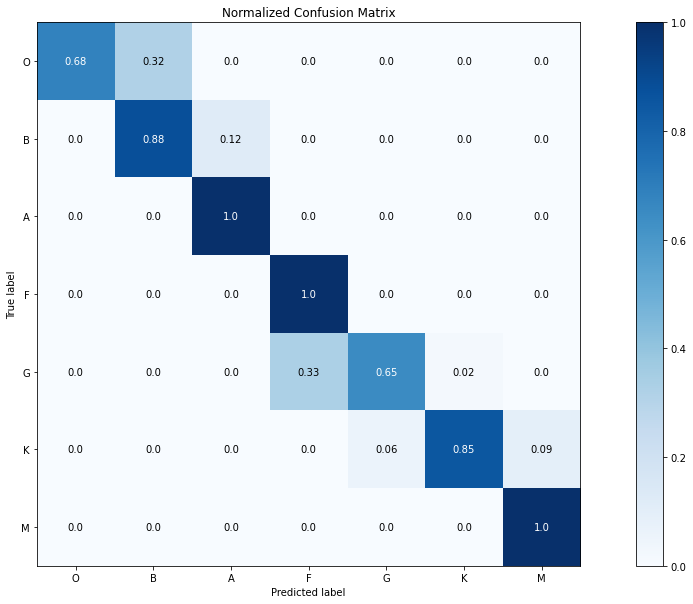

In [19]:
plot_confusion_matrix(spectral, deep_nw_lsst_classes['spectral'], labels=SPECTRAL_NAMES, normalize=True)

## Euclid + LSST (minus y), with SED weighting, MW absorption

In [20]:
deep_w_lsst = Table.read('/home/aalvarez/Phosphoros/Results/SC7_Stars/Deep_W_lsst/phz_cat.fits')
len(deep_w_lsst)

1724897

In [21]:
deep_w_lsst_classes = classes_from_sed_column(deep_w_lsst['SED'])

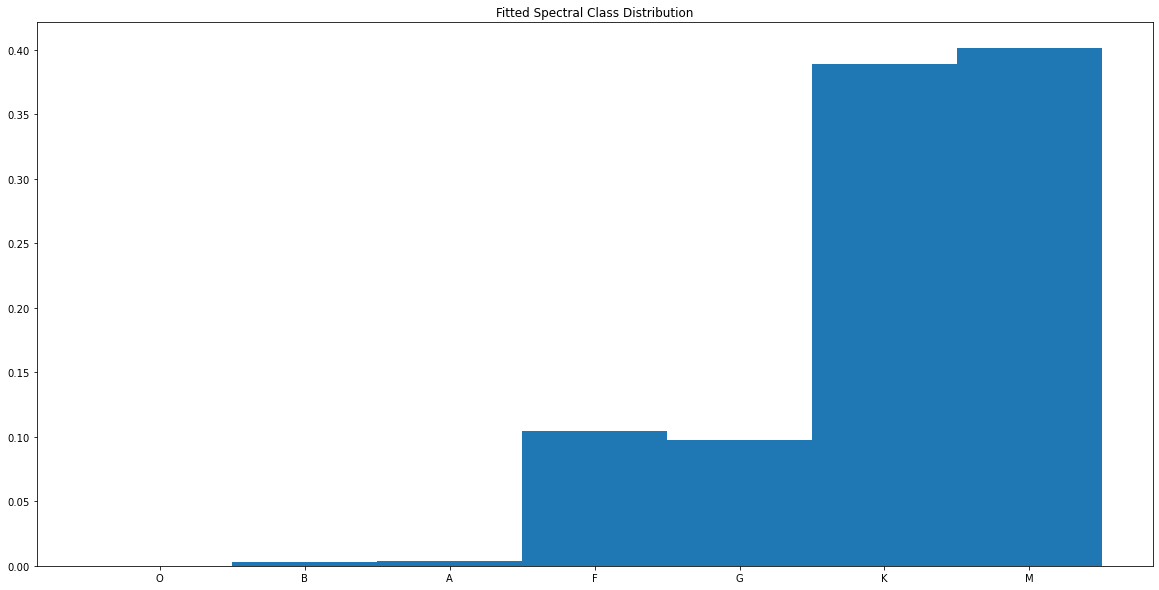

In [22]:
plt.figure()
categorical_hist(plt.gca(), deep_w_lsst_classes['spectral'], SPECTRAL_NAMES)
plt.title('Fitted Spectral Class Distribution')
plt.show()

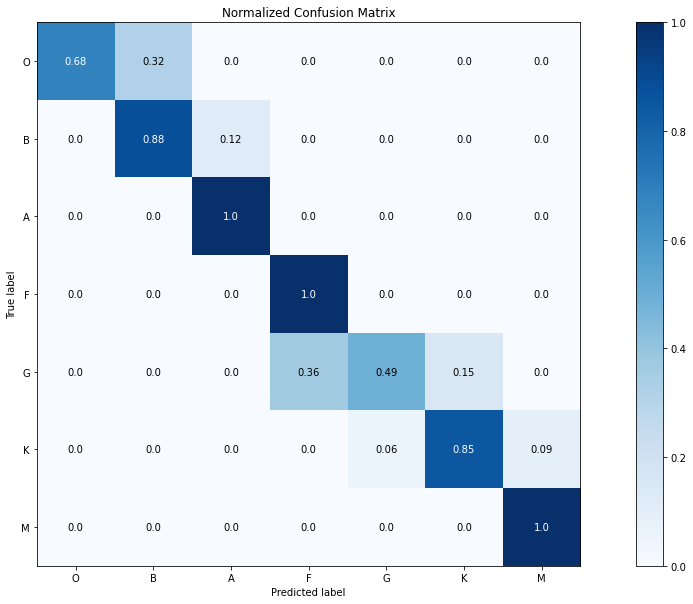

In [23]:
plot_confusion_matrix(spectral, deep_w_lsst_classes['spectral'], labels=SPECTRAL_NAMES, normalize=True)